<a href="https://colab.research.google.com/github/elliehaber/icd_code_pred/blob/master/biobert_HospCourse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
import io
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
import torch
print(torch.__version__)


1.2.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/')

In [4]:
#patient notes data
df_notes = pd.read_csv('NOTEEVENTS.csv')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
len(df_notes)

2083180

In [0]:
#icd diagnoses data
df_icd_diag = pd.read_csv('DIAGNOSES_ICD 2.csv')

106379
['4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881', '5990', '53081']


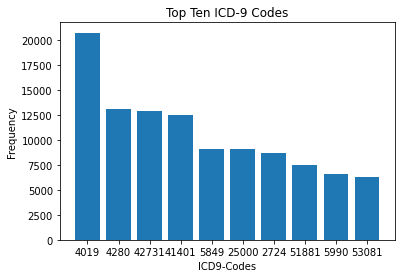

In [6]:
#Identify the top 10 occurring ICD-9 Codes
import matplotlib.pyplot as plt

df_icd_diag.head()
freq = df_icd_diag['ICD9_CODE'].value_counts()[:10].index.tolist()
x = df_icd_diag['ICD9_CODE'].value_counts()[:50].index.tolist()


print(sum(df_icd_diag['ICD9_CODE'].value_counts()[:10]))
freq_val = df_icd_diag['ICD9_CODE'].value_counts()[:10]
plt.bar(freq, freq_val)
plt.title('Top Ten ICD-9 Codes')
plt.ylabel('Frequency')
plt.xlabel('ICD9-Codes')

print(freq)

In [0]:
#Filter for notes with discharge summary
df_notes_discharge_summ = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [0]:
df_notes_discharge_summ_last = (df_notes_discharge_summ.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1)).reset_index()
assert df_notes_discharge_summ_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [0]:
df_icd_notes = pd.merge(df_icd_diag[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']], \
df_notes_discharge_summ_last[['SUBJECT_ID', 'HADM_ID', 'TEXT']], on= ['SUBJECT_ID', 'HADM_ID'], how = 'left'
)

assert len(df_icd_diag) == len(df_icd_notes), 'Number of rows increased'

In [12]:
len(df_icd_notes)

651047

In [10]:
#filter for first admission
df_icd_notes = df_icd_notes[df_icd_notes.ICD9_CODE.isin(freq)]

t = df_icd_notes.drop_duplicates(subset='HADM_ID', keep="first", inplace=True)
df_icd_notes = df_icd_notes.dropna(how='any',subset=['TEXT'])

df_icd_notes

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,TEXT
31,112,174105,4.0,41401,Admission Date: [**2194-6-13**] Dischar...
35,113,109976,3.0,53081,Admission Date: [**2140-12-12**] Discha...
36,114,178393,1.0,41401,Admission Date: [**2146-8-29**] Dischar...
50,115,114585,9.0,5990,Admission Date: [**2194-10-16**] ...
67,117,140784,5.0,4280,Admission Date: [**2133-4-7**] Discharge ...
...,...,...,...,...,...
650962,97164,109302,3.0,51881,Admission Date: [**2134-11-26**] ...
650986,97484,172304,4.0,4019,Admission Date: [**2196-8-19**] ...
650993,97488,152542,5.0,42731,Admission Date: [**2128-4-8**] D...
651007,97488,161999,8.0,5990,Admission Date: [**2128-8-27**] ...


In [11]:
x = df_icd_notes.TEXT.values[7:8]
for i in x:
  print(i)

In [0]:
#Extract Hospital Course section of notes

df_icd_notes
lst = []
for i in df_icd_notes['TEXT']:
  i = str(i).lower()
  if 'concise summary of hospital course as follows:' in i:
    start = i.find('concise summary of hospital course as follows:') 
    lst.append(i[start+46:])
  elif 'hospital course:' in i:
    start = i.find('hospital course:') 
    lst.append(i[start+16:])
  else: 
    lst.append('not valid')

df_icd_notes['Hosp_course'] = lst

df_icd_notes = df_icd_notes[df_icd_notes.Hosp_course != 'not valid']


In [13]:
#Extract History of Present Illness section of notes

df_icd_notes
lst = []
for i in df_icd_notes['TEXT']:
  i = str(i).lower()
  if 'history of present illness' in i:
    start = i.find('history of present illness:')
    lst.append(i[start+27:])
  else:
    lst.append('not valid')


df_icd_notes['hist_pres_illness'] = lst

df_icd_notes = df_icd_notes[df_icd_notes.hist_pres_illness != 'not valid']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
df_icd_notes = df_icd_notes.dropna(how='any',subset=['Hosp_course'])
df_icd_notes = df_icd_notes.dropna(how='any',subset=['hist_pres_illness'])


In [15]:
df_icd_notes

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,TEXT,Hosp_course,hist_pres_illness
31,112,174105,4.0,41401,Admission Date: [**2194-6-13**] Dischar...,gi: the\npatient was felt to likely have ano...,the patient is a [**age over 90 **]-year-old...
35,113,109976,3.0,53081,Admission Date: [**2140-12-12**] Discha...,the patient was admitted to the intensive\nc...,the patient is a 35 year old\ngentleman who ...
36,114,178393,1.0,41401,Admission Date: [**2146-8-29**] Dischar...,the patient was admitted to the [**hospital1...,this is a 48-year-old man in\ngenerally good...
50,115,114585,9.0,5990,Admission Date: [**2194-10-16**] ...,\nshe was taken to the or by dr. [**first name...,\nthe patient is a 75 y/o female who presents ...
67,117,140784,5.0,4280,Admission Date: [**2133-4-7**] Discharge ...,\n1. hypotension. the patient was admitted t...,the patient is a 49 year old\nwoman with a h...
...,...,...,...,...,...,...,...
650962,97164,109302,3.0,51881,Admission Date: [**2134-11-26**] ...,\nassessment and plan: ms. [**known lastname 2...,\nms. [**known lastname 2564**] is an 83 y/o f...
650986,97484,172304,4.0,4019,Admission Date: [**2196-8-19**] ...,"\nthe patient tolerated her procedure well, an...",\n79 f with no past oncologic history who pres...
650993,97488,152542,5.0,42731,Admission Date: [**2128-4-8**] D...,\nmr. [**known lastname 17811**] was admitted ...,\n66m transferred from [**hospital1 18**] [**l...
651007,97488,161999,8.0,5990,Admission Date: [**2128-8-27**] ...,\n*)neuro: patient was admitted [**2128-8-27**...,\nthe patient is a 67 year old right handed ma...


In [16]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [17]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [18]:
!pip install biobert-embedding

In [19]:
!pip install transformers

In [20]:
pip install biobert-embedding==0.1.1


ERROR: Could not find a version that satisfies the requirement biobert-embedding==0.1.1 (from versions: 0.1.2)
ERROR: No matching distribution found for biobert-embedding==0.1.1


In [21]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

In [0]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
import string


def preprocess(text):  
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ""))
    text = text.lower().translate(t)
    text = text.replace('\n','')
    return text

In [0]:

# labels_dict = {}
# num = 0
# for i in freq:
#   labels_dict[str(i)] = num
#   num+= 1

# print(labels_dict)
class2idx = {
    '4019': 0,
    '4280': 1,
    '42731': 2,
    '41401': 3,
    '5849': 4,
    '25000': 5,
    '2724': 6,
    '51881': 7,
    '5990': 8,
    '53081': 9
}

# class2idx = {
#     4019: 0,
#     4280: 1,
#     42731: 2,
#     41401: 3,
#     5849: 4,
#     25000: 5,
#     2724: 6,
#     51881: 7,
#     5990: 8,
#     53081: 9
# }

idx2class = {v: k for k, v in class2idx.items()}


df_icd_notes['ICD9_CODE'].replace(class2idx, inplace=True)



In [27]:
df_icd_notes

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,TEXT,Hosp_course,hist_pres_illness
31,112,174105,4.0,3,Admission Date: [**2194-6-13**] Dischar...,gi: the\npatient was felt to likely have ano...,the patient is a [**age over 90 **]-year-old...
35,113,109976,3.0,9,Admission Date: [**2140-12-12**] Discha...,the patient was admitted to the intensive\nc...,the patient is a 35 year old\ngentleman who ...
36,114,178393,1.0,3,Admission Date: [**2146-8-29**] Dischar...,the patient was admitted to the [**hospital1...,this is a 48-year-old man in\ngenerally good...
50,115,114585,9.0,8,Admission Date: [**2194-10-16**] ...,\nshe was taken to the or by dr. [**first name...,\nthe patient is a 75 y/o female who presents ...
67,117,140784,5.0,1,Admission Date: [**2133-4-7**] Discharge ...,\n1. hypotension. the patient was admitted t...,the patient is a 49 year old\nwoman with a h...
...,...,...,...,...,...,...,...
650962,97164,109302,3.0,7,Admission Date: [**2134-11-26**] ...,\nassessment and plan: ms. [**known lastname 2...,\nms. [**known lastname 2564**] is an 83 y/o f...
650986,97484,172304,4.0,0,Admission Date: [**2196-8-19**] ...,"\nthe patient tolerated her procedure well, an...",\n79 f with no past oncologic history who pres...
650993,97488,152542,5.0,2,Admission Date: [**2128-4-8**] D...,\nmr. [**known lastname 17811**] was admitted ...,\n66m transferred from [**hospital1 18**] [**l...
651007,97488,161999,8.0,8,Admission Date: [**2128-8-27**] ...,\n*)neuro: patient was admitted [**2128-8-27**...,\nthe patient is a 67 year old right handed ma...


In [0]:
labels = df_icd_notes.ICD9_CODE.values
labels = labels.astype(np.long)

sentences_hosp = df_icd_notes.Hosp_course.values
sentences_hosp = sentences_hosp.astype('str')

test_labels = labels[27001:30202]
test_sent = sentences_hosp[27001:30202]

# test_labels = labels[2700:3020]
# test_sent = sentences_hosp[2700:3020]

for i in range(len(test_sent)):
    sent = test_sent[i]
    sent = preprocess(sent)
    test_sent[i] = sent
# sentences_hist = df_icd_notes.hist_pres_illness.values
# sentences_hist = sentences_hist.astype(np.string_)
# sentences = df_icd_notes.TEXT.values
# sentences = sentences.astype(np.string_)


# labels = labels[:27000]
# sentences_hosp = sentences_hosp[:27000]
labels = labels[:27000]
sentences_hosp = sentences_hosp[:27000]


for i in range(len(sentences_hosp)):
    sent = sentences_hosp[i]
    sent = preprocess(sent)
    sentences_hosp[i] = sent


In [29]:
sentences_hosp[0]

'
'

In [30]:
sentences_hosp[0]

' 
 '

In [0]:
!tar -xzf biobert_v1.1_pubmed.tar.gz

In [0]:
import os
from pytorch_pretrained_bert.convert_tf_checkpoint_to_pytorch import convert_tf_checkpoint_to_pytorch
path_bin = '/content/drive/My Drive/biobert_v1.1_pubmed_pytorch_model/pytorch_model.bin'
path_bert = '/content/drive/My Drive/biobert_v1.1_pubmed/'

if (not os.path.exists(path_bin)):
  convert_tf_checkpoint_to_pytorch(
  path_bert + "biobert_model.ckpt",
  path_bert + "bert_config.json",
  path_bert + "pytorch_model.bin"
  )

In [27]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed', do_lower_case=True)

Loading BERT tokenizer...


In [28]:
# Print the original sentence.
print(' Original: ', sentences_hosp[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_hosp[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_hosp[0])))

 Original: 
Tokenized:  
Token IDs:  [176, 1182, 1103, 27420, 1108, 1464, 1106, 2620, 1138, 1330, 9793, 23449, 14840, 1112, 20021, 3121, 4807, 1104, 1117, 1143, 4371, 14426, 15631, 1116, 1105, 1126, 20504, 1103, 5351, 1125, 1161, 1607, 1104, 1119, 8031, 12809, 11179, 1200, 185, 7777, 9012, 1107, 1103, 1763, 1115, 1108, 7877, 2913, 1103, 5351, 1108, 1464, 1106, 4752, 174, 1403, 1181, 1106, 17459, 1111, 1874, 21754, 8974, 1112, 1218, 1112, 7173, 9793, 1103, 5351, 20963, 2786, 4120, 1106, 1103, 178, 10182, 3245, 8005, 25195, 4807, 1108, 7235, 24661, 1906, 1103, 5351, 1108, 1678, 1111, 174, 1403, 1181, 1113, 1134, 2737, 12595, 170, 1996, 22904, 4412, 23449, 14840, 1185, 12104, 9793, 1103, 23449, 14840, 1108, 1394, 24653, 10681, 5351, 1108, 2786, 1598, 1113, 178, 1964, 6875, 5250, 1633, 7231, 15391, 10024, 1665, 26846, 1127, 1723, 1105, 1103, 5351, 1108, 4441, 1113, 17963, 178, 1964, 1116, 1120, 1155, 1551, 1105, 1112, 8508, 4854, 1108, 1316, 1103, 27420, 1144, 1330, 2004, 1104, 1143, 4371,

In [29]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_hosp:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_hosp[0])
print('Token IDs:', input_ids[0])

Original:   
Token IDs: tensor([  101,   176,  1182,  1103, 27420,  1108,  1464,  1106,  2620,  1138,
         1330,  9793, 23449, 14840,  1112, 20021,  3121,  4807,  1104,  1117,
         1143,  4371, 14426, 15631,  1116,  1105,  1126, 20504,  1103,  5351,
         1125,  1161,  1607,  1104,  1119,  8031, 12809, 11179,  1200,   185,
         7777,  9012,  1107,  1103,  1763,  1115,  1108,  7877,  2913,  1103,
         5351,  1108,  1464,  1106,  4752,   174,  1403,  1181,  1106, 17459,
         1111,  1874, 21754,  8974,  1112,  1218,  1112,  7173,  9793,  1103,
         5351, 20963,  2786,  4120,  1106,  1103,   178, 10182,  3245,  8005,
        25195,  4807,  1108,  7235, 24661,  1906,  1103,  5351,  1108,  1678,
         1111,   174,  1403,  1181,  1113,  1134,  2737, 12595,   170,  1996,
        22904,  4412, 23449, 14840,  1185, 12104,  9793,  1103, 23449, 14840,
         1108,  1394, 24653, 10681,  5351,  1108,  2786,  1598,  1113,   178,
         1964,  6875,  5250,  1633,  723

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                          random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [32]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy constru

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 12

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [34]:
model = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/biobert_v1.1_pubmed_pytorch_model/', num_labels=10)
model.cuda()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:

param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01}
]



In [36]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=1e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
errors = {"0": 0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}
total = {"0": 0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    print('-----------------------')
    print('pred: ', pred_flat)
    labels_flat = labels.flatten()
    print('labels: ', labels_flat)
    
    ##determine frequent errors
    for i in range(len(pred_flat)):
      if labels_flat[i] != pred_flat[i]:
        errors[str(labels_flat[i])] += 1
      total[str(labels_flat[i])] += 1
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize


def aucscore(labels, preds):
  print(preds)
  pred_flat = np.max(preds, axis=1).flatten()
  print(pred_flat)
  labels_flat = labels
  print('x')
  micro = roc_auc_score(labels_flat, pred_flat, average='micro', multi_class='ovo')
  print('x')
  macro = roc_auc_score(labels_flat, pred_flat, average='macro', multi_class='ovo')
  weighted = roc_auc_score(labels_flat, pred_flat, average='weighted', multi_class='ovo')

  return micro, macro, weighted

In [0]:
def f1score(labels, preds):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  micro = f1_score(labels_flat, pred_flat, average='micro')
  macro = f1_score(labels_flat, pred_flat, average='macro')
  weighted = f1_score(labels_flat, pred_flat, average='weighted')

  return micro, macro, weighted


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [41]:
from sklearn.metrics import f1_score

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  total_eval_loss=0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass

    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  f1_micr, f1_macr, f1_weight = 0,0,0
  auc_micr, auc_macr, auc_weight = 0,0,0
  nb_eval_steps, nb_eval_examples = 0, 0
 
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    total_eval_loss+= loss.item()
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    tmp_f1_micr, tmp_f1_macr, tmp_f1_weight = f1score(label_ids, logits)
    # tmp_auc_micr, tmp_auc_macr, tmp_auc_weight = aucscore(label_ids, logits)
    eval_accuracy += tmp_eval_accuracy

    #calculate f1 scores
    f1_micr += tmp_f1_micr
    f1_macr += tmp_f1_macr
    f1_weight += tmp_f1_weight
    print('temp eval acc: ', tmp_eval_accuracy)

    #calculate auc
    # auc_micr += tmp_auc_micr
    # auc_macr += tmp_auc_macr
    # auc_weight += tmp_auc_weight

    nb_eval_steps += 1
  print('TOTAL EVAL LOSS: ', total_eval_loss/len(validation_dataloader))
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  print('F1 micro: ', f1_micr/nb_eval_steps)
  print('F1 macro: ', f1_macr/nb_eval_steps)
  print('F1 weighted: ', f1_weight/nb_eval_steps)


  # print('AUC macro: ', auc_macr/nb_eval_steps )

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.6700699122452443
-----------------------
pred:  [3 7 4 1 1 0 1 1 7 3 1 7]
labels:  [3 7 2 4 1 8 1 1 7 3 1 9]
temp eval acc:  0.6666666666666666
-----------------------
pred:  [3 7 3 7 0 1 8 1 7 3 1 4]
labels:  [0 7 3 2 8 1 3 1 7 3 4 1]
temp eval acc:  0.5
-----------------------
pred:  [4 1 7 4 2 7 7 2 3 0 1 7]
labels:  [7 1 7 4 1 8 5 2 8 8 1 4]
temp eval acc:  0.4166666666666667
-----------------------
pred:  [2 7 7 7 3 7 1 2 7 7 0 1]
labels:  [2 1 7 1 0 0 4 7 7 7 3 3]
temp eval acc:  0.3333333333333333
-----------------------
pred:  [1 0 3 0 0 1 4 2 7 1 3 7]
labels:  [1 0 3 0 8 7 7 1 7 1 3 0]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [1 1 7 0 7 7 4 0 3 4 7 4]
labels:  [2 7 2 7 4 7 4 0 3 7 7 4]
temp eval acc:  0.5
-----------------------
pred:  [4 1 3 8 2 3 0 2 7 1 3 8]
labels:  [0 1 3 8 5 3 8 1 7 7 0 8]
temp eval acc:  0.5
-----------------------
pred:  [8 2 7 4 3 3 3 4 4 4 1 3]
labels:  [8 2 0 4 8 2 0 0 4 4 4 3]
temp eval acc:  0.5
-------------

Epoch:  25%|██▌       | 1/4 [26:49<1:20:27, 1609.06s/it]

-----------------------
pred:  [4 8 1 0 2 3 1 0 0 7 1 7]
labels:  [4 0 3 8 6 3 1 5 0 7 2 7]
temp eval acc:  0.5
TOTAL EVAL LOSS:  1.8103227615356445
Validation Accuracy: 0.5159259259259258
F1 micro:  0.5159259259259258
F1 macro:  0.39708307489101174
F1 weighted:  0.4972753193308746
Train loss: 1.4158718527393577
-----------------------
pred:  [3 7 4 1 1 0 1 4 7 3 1 7]
labels:  [3 7 2 4 1 8 1 1 7 3 1 9]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [0 7 3 7 0 1 8 1 7 8 4 8]
labels:  [0 7 3 2 8 1 3 1 7 3 4 1]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [2 1 7 4 2 8 7 2 8 8 1 4]
labels:  [7 1 7 4 1 8 5 2 8 8 1 4]
temp eval acc:  0.75
-----------------------
pred:  [0 7 7 7 0 7 4 2 7 7 0 3]
labels:  [2 1 7 1 0 0 4 7 7 7 3 3]
temp eval acc:  0.5
-----------------------
pred:  [1 0 3 8 0 2 4 0 7 1 3 7]
labels:  [1 0 3 0 8 7 7 1 7 1 3 0]
temp eval acc:  0.5
-----------------------
pred:  [1 1 7 0 1 7 4 0 3 4 7 0]
labels:  [2 7 2 7 4 7 4 0 3 7 7 4]
tem

Epoch:  50%|█████     | 2/4 [53:38<53:38, 1609.17s/it]  

-----------------------
pred:  [4 8 4 0 2 3 1 0 0 7 0 7]
labels:  [4 0 3 8 6 3 1 5 0 7 2 7]
temp eval acc:  0.5
TOTAL EVAL LOSS:  1.2459924221038818
Validation Accuracy: 0.5366666666666665
F1 micro:  0.5366666666666665
F1 macro:  0.4202489472706407
F1 weighted:  0.5167531131420021
Train loss: 1.3051794801229313
-----------------------
pred:  [3 7 4 1 1 0 1 3 1 3 1 7]
labels:  [3 7 2 4 1 8 1 1 7 3 1 9]
temp eval acc:  0.5
-----------------------
pred:  [3 7 3 1 0 1 8 1 7 3 4 4]
labels:  [0 7 3 2 8 1 3 1 7 3 4 1]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [2 1 7 4 2 8 1 2 3 8 1 4]
labels:  [7 1 7 4 1 8 5 2 8 8 1 4]
temp eval acc:  0.6666666666666666
-----------------------
pred:  [0 7 7 7 5 7 1 1 7 1 0 3]
labels:  [2 1 7 1 0 0 4 7 7 7 3 3]
temp eval acc:  0.25
-----------------------
pred:  [1 0 3 8 0 2 4 1 7 1 3 7]
labels:  [1 0 3 0 8 7 7 1 7 1 3 0]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [3 1 7 0 1 7 4 0 3 4 7 4]
labels:  [2 7 2 7 4 7 4 

Epoch:  75%|███████▌  | 3/4 [1:20:28<26:49, 1609.57s/it]

-----------------------
pred:  [4 8 1 0 2 3 1 0 0 7 1 7]
labels:  [4 0 3 8 6 3 1 5 0 7 2 7]
temp eval acc:  0.5
TOTAL EVAL LOSS:  1.3037821054458618
Validation Accuracy: 0.5333333333333335
F1 micro:  0.5333333333333335
F1 macro:  0.41468769007790174
F1 weighted:  0.5173362995029662
Train loss: 1.1973727680577173
-----------------------
pred:  [3 7 4 1 1 0 1 1 7 3 1 7]
labels:  [3 7 2 4 1 8 1 1 7 3 1 9]
temp eval acc:  0.6666666666666666
-----------------------
pred:  [3 7 3 7 0 1 0 1 7 8 4 4]
labels:  [0 7 3 2 8 1 3 1 7 3 4 1]
temp eval acc:  0.5
-----------------------
pred:  [4 4 7 4 2 8 7 2 8 8 1 4]
labels:  [7 1 7 4 1 8 5 2 8 8 1 4]
temp eval acc:  0.6666666666666666
-----------------------
pred:  [0 7 7 7 0 7 4 2 7 7 2 1]
labels:  [2 1 7 1 0 0 4 7 7 7 3 3]
temp eval acc:  0.4166666666666667
-----------------------
pred:  [1 0 3 0 0 2 4 0 7 4 3 7]
labels:  [1 0 3 0 8 7 7 1 7 1 3 0]
temp eval acc:  0.5
-----------------------
pred:  [1 1 7 0 1 7 4 0 3 4 7 4]
labels:  [2 7 2 7 4 7 4 

Epoch: 100%|██████████| 4/4 [1:47:20<00:00, 1610.20s/it]

-----------------------
pred:  [4 8 1 0 2 3 1 0 0 7 4 7]
labels:  [4 0 3 8 6 3 1 5 0 7 2 7]
temp eval acc:  0.5
TOTAL EVAL LOSS:  1.2596884965896606
Validation Accuracy: 0.5344444444444442
F1 micro:  0.5344444444444442
F1 macro:  0.4169543221916238
F1 weighted:  0.5161281352392464


In [42]:
errors

{'0': 547,
 '1': 913,
 '2': 521,
 '3': 379,
 '4': 709,
 '5': 397,
 '6': 223,
 '7': 535,
 '8': 548,
 '9': 303}

In [43]:
total

{'0': 1432,
 '1': 1508,
 '2': 1116,
 '3': 1716,
 '4': 1464,
 '5': 432,
 '6': 224,
 '7': 1588,
 '8': 988,
 '9': 332}

In [44]:
import os
from transformers import WEIGHTS_NAME, CONFIG_NAME

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
print("Saving model to %s" % output_dir)
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_pretrained(output_dir)
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [45]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sent:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_sent[0])
print('Token IDs:', input_ids[0])

Original:   
Token IDs: tensor([  101,  1112,  3025,  1107,  1103,  6857,  1182,   182,  1197,  1227,
         1314, 16124,  1108,  3175,  1121,  1796, 14467, 24834,  1158,   170,
          188, 27250,  4184,  1348,  2004,  1120,  1313,  3621, 17288,  1555,
        20489,  1193,  2374,  5351,  1852, 10296,  1105,  1119,  1108, 11478,
         1643, 12736,  3464,  7854,  1183,  1589,  4455,  1111, 17688,  6059,
         1142,  1529,  8766,  3329,  2386,  1366,  2229,   172,  1204, 16278,
          176,  1182, 27231, 15360, 27231,  1373, 22922,  4400,  3073,  4184,
         8074,  1250,  1142,  1108,  3890,  1166,  1317,  1552,  5709,  1113,
         1119,  1108,  1814,  1106,  1103,  3389,  1395,  1187,  1119,  6775,
         1200, 10781,  1204,  1126,   170, 12148,  1596, 11727,  5627,  1105,
         1884, 15789,  1616, 18593, 13981, 14867,  4964,   193,  4268,  1267,
        13035,  2592,  1111, 13467,  4068, 14467, 24834,  1158,  6059,  1119,
         1108,  3175,  1106,  1103,   17

In [46]:
test_inputs, _, test_labels, _ = train_test_split(input_ids, labels, 
                                                          random_state=2018, test_size=0.1)
test_masks, _, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)

batch_size = 12

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [47]:
#Test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

#initialize vars
f1_micr_test = 0
f1_macr_test = 0
f1_weight_test = 0
nb_eval_steps_test = 0

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  # predictions.append(logits)
  # true_labels.append(label_ids)

  tmp_f1_micr, tmp_f1_macr, tmp_f1_weight = f1score(label_ids, logits)

  #calculate f1 scores
  f1_micr_test += tmp_f1_micr
  f1_macr_test += tmp_f1_macr
  f1_weight_test += tmp_f1_weight
  nb_eval_steps_test += 1

print('F1 micro test: ', f1_micr_test/nb_eval_steps_test)
print('F1 macro test: ', f1_macr_test/nb_eval_steps_test)
print('F1 weight test: ', f1_weight_test/nb_eval_steps_test)
print('    DONE.')

Predicting labels for 3,201 test sentences...
F1 micro test:  0.5277777777777781
F1 macro test:  0.41012142124666956
F1 weight test:  0.5123225809684144
    DONE.
